In [2]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [25]:
ckd_data <- read_csv("https://raw.githubusercontent.com/callen02/DSCI100_Group_25_Project/main/ckd_clean.csv")
names(ckd_data) <- gsub(" ", ".", names(ckd_data))
#filtered out columns that are non numeric
ckd_data_tidy <- ckd_data %>% 
            mutate(Class = as_factor(Class)) %>%
            select(-Red.Blood.Cells, -Pus.Cell, -Pus.Cell.clumps, -Bacteria, -Hypertension, -Diabetes.Mellitus, -Appetite, -Pedal.Edema, -Coronary.Artery.Disease, - Anemia)
ckd_data_tidy

Parsed with column specification:
cols(
  .default = col_double(),
  `Red Blood Cells` = col_character(),
  `Pus Cell` = col_character(),
  `Pus Cell clumps` = col_character(),
  Bacteria = col_character(),
  Hypertension = col_character(),
  `Diabetes Mellitus` = col_character(),
  `Coronary Artery Disease` = col_character(),
  Appetite = col_character(),
  `Pedal Edema` = col_character(),
  Anemia = col_character()
)

See spec(...) for full column specifications.



Age,Blood.Pressure,Specific.Gravity,Albumin,Sugar,Blood.Glucose.Random,Blood.Urea,Serum.Creatinine,Sodium,Potassium,Hemoglobin,Packed.Cell.Volume,White.Blood.Cell.Count,Red.Blood.Cell.Count,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
48,70,1.005,4,0,117,56,3.8,111,2.5,11.2,32,6700,3.9,1
53,90,1.020,2,0,70,107,7.2,114,3.7,9.5,29,12100,3.7,1
63,70,1.010,3,0,380,60,2.7,131,4.2,10.8,32,4500,3.8,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,80,1.020,0,0,100,26,0.6,137,4.4,15.8,49,6600,5.4,0
17,60,1.025,0,0,114,50,1.0,135,4.9,14.2,51,7200,5.9,0
58,80,1.025,0,0,131,18,1.1,141,3.5,15.8,53,6800,6.1,0


In [88]:
#training and testing data, # class means whether they have CKD or not. 1 = Yes, 0 = No
set.seed(123)
ckd_split <- initial_split(ckd_data_tidy, prop = 0.75, strata = Class)
ckd_training <- training(ckd_split)
ckd_testing <- testing(ckd_split)

ckd_training
ckd_testing

Age,Blood.Pressure,Specific.Gravity,Albumin,Sugar,Blood.Glucose.Random,Blood.Urea,Serum.Creatinine,Sodium,Potassium,Hemoglobin,Packed.Cell.Volume,White.Blood.Cell.Count,Red.Blood.Cell.Count,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
48,70,1.005,4,0,117,56,3.8,111,2.5,11.2,32,6700,3.9,1
53,90,1.020,2,0,70,107,7.2,114,3.7,9.5,29,12100,3.7,1
63,70,1.010,3,0,380,60,2.7,131,4.2,10.8,32,4500,3.8,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,80,1.020,0,0,100,26,0.6,137,4.4,15.8,49,6600,5.4,0
17,60,1.025,0,0,114,50,1.0,135,4.9,14.2,51,7200,5.9,0
58,80,1.025,0,0,131,18,1.1,141,3.5,15.8,53,6800,6.1,0


Age,Blood.Pressure,Specific.Gravity,Albumin,Sugar,Blood.Glucose.Random,Blood.Urea,Serum.Creatinine,Sodium,Potassium,Hemoglobin,Packed.Cell.Volume,White.Blood.Cell.Count,Red.Blood.Cell.Count,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
69,70,1.01,3,4,264,87,2.7,130,4.0,12.5,37,9600,4.1,1
73,80,1.02,2,0,253,142,4.6,138,5.8,10.5,33,7200,4.3,1
46,60,1.01,1,0,163,92,3.3,141,4.0,9.8,28,14600,3.2,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
15,80,1.025,0,0,93,17,0.9,136,3.9,16.7,50,6200,5.2,0
50,80,1.020,0,0,137,46,0.8,139,5.0,14.1,45,9500,4.6,0
42,70,1.025,0,0,75,31,1.2,141,3.5,16.5,54,7800,6.2,0


In [101]:
#Recipe
#selection of variables of what I imagine is of more imporant when determining CKD
ckd_recipe <- recipe(Class ~ Blood.Pressure + Albumin + Age + Blood.Glucose.Random + 
                     Blood.Urea, data = ckd_training) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())
ckd_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [102]:
#Model that helps find the optimal K value
ckd_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")
ckd_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [103]:
#10 V-fold function
ckd_vfold <- vfold_cv(ckd_training, v = 10, strata = Class)

In [104]:
#Workflow, honestly don't know if it is correct
ckd_workflow <- workflow() %>%
            add_recipe(ckd_recipe) %>%
            add_model(ckd_spec) %>%
            tune_grid(resamples = ckd_vfold, grid = 10) %>%
            collect_metrics()
            
ckd_workflow
            

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9742424,10,0.018076293,Model01
2,roc_auc,binary,0.9796296,10,0.016666667,Model01
3,accuracy,binary,0.9909091,10,0.009090909,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,binary,0.9833333,10,0.01666667,Model09
15,accuracy,binary,0.9414336,10,0.01286524,Model10
15,roc_auc,binary,0.9833333,10,0.01666667,Model10


In [105]:
#Filter for accuracy
ckd_accuracy <- ckd_workflow %>%
                 filter(.metric == "accuracy")
ckd_accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9742424,10,0.018076293,Model01
3,accuracy,binary,0.9909091,10,0.009090909,Model02
4,accuracy,binary,0.9909091,10,0.009090909,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.9491259,10,0.01390350,Model08
13,accuracy,binary,0.9491259,10,0.01390350,Model09
15,accuracy,binary,0.9414336,10,0.01286524,Model10


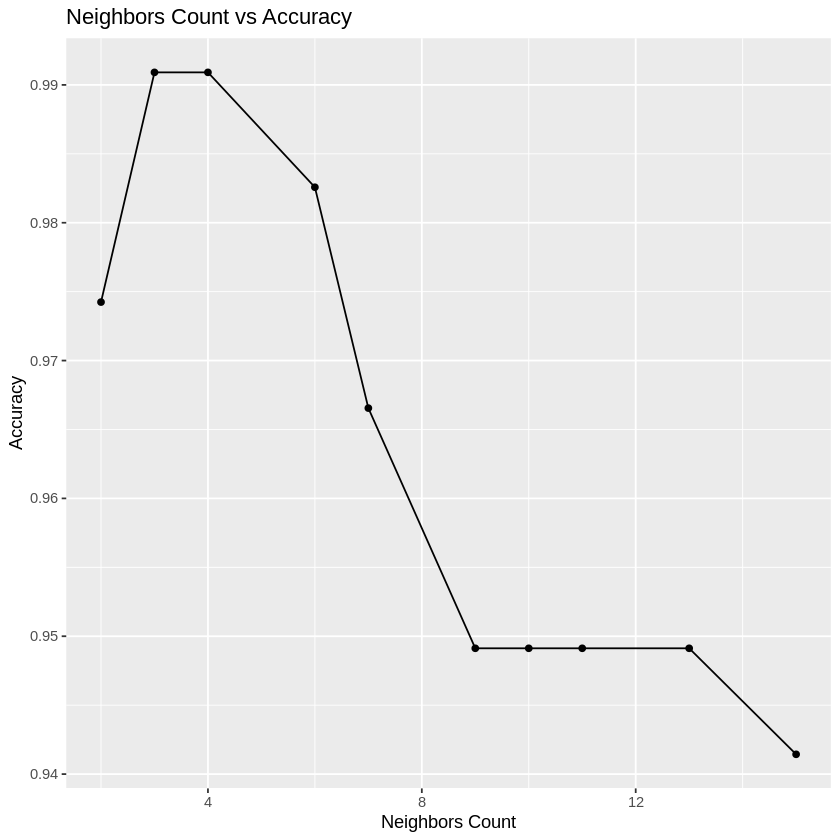

In [106]:
#Plot to find the optimal K
cross_val_plot <- ckd_accuracy %>%
                  ggplot(aes(x= neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Neighbors Count", y = "Accuracy", title = "Neighbors Count vs Accuracy")

cross_val_plot

In [111]:
#Model with optimal k value
ckd_optimal_k <- nearest_neighbor(weight_func = "rectangular", neighbor = 4) %>%
                set_engine("kknn") %>%
                set_mode("classification")

ckd_optimal_k
            

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 4
  weight_func = rectangular

Computational engine: kknn 


In [112]:
#Fitted Model
ckd_fit <- workflow() %>%
             add_recipe(ckd_recipe) %>%
             add_model(ckd_optimal_k) %>%
             fit(data = ckd_training)

ckd_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~4, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.01666667
Best kernel: rectangular
Best k: 4

In [113]:
#Predictions and accuracy, seems awfully high but I can't tell if I made an error
set.seed(300)
ckd_predictions <- predict(ckd_fit, ckd_testing) %>%
                     bind_cols(ckd_testing)
ckd_predictions

ckd_metrics <- ckd_predictions %>%
                 metrics(truth = Class, .pred_class) %>%
                 filter(.metric== "accuracy")
ckd_metrics

.pred_class,Age,Blood.Pressure,Specific.Gravity,Albumin,Sugar,Blood.Glucose.Random,Blood.Urea,Serum.Creatinine,Sodium,Potassium,Hemoglobin,Packed.Cell.Volume,White.Blood.Cell.Count,Red.Blood.Cell.Count,Class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,69,70,1.01,3,4,264,87,2.7,130,4.0,12.5,37,9600,4.1,1
1,73,80,1.02,2,0,253,142,4.6,138,5.8,10.5,33,7200,4.3,1
0,46,60,1.01,1,0,163,92,3.3,141,4.0,9.8,28,14600,3.2,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,15,80,1.025,0,0,93,17,0.9,136,3.9,16.7,50,6200,5.2,0
0,50,80,1.020,0,0,137,46,0.8,139,5.0,14.1,45,9500,4.6,0
0,42,70,1.025,0,0,75,31,1.2,141,3.5,16.5,54,7800,6.2,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9736842


In [114]:
#Sample 
new_obs <- tibble(Blood.Pressure = 120, Age = 65, Albumin = 4, Blood.Glucose.Random = 350, Blood.Urea = 210) 
ckd_new_obs <- predict(ckd_fit, new_obs)
ckd_new_obs

.pred_class
<fct>
1
